In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import statsmodels.api as sm

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

In [68]:
def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    '''Prints the AUC scores for training and testing data
    and returns testing score'''

    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    print('Training AUC:' , roc_auc_score(y_train, y_train_score))
    print('Testing AUC: ', roc_auc_score(y_test, y_test_score))
    
    return y_test_score



def plot_roc_curve(y_test, y_test_score):
    '''Plot ROC curve for testing data'''
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], 'k — ')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()

#https://medium.com/swlh/how-to-code-and-evaluate-of-decision-trees-2d94093b3c1a

In [69]:
path = pd.read_csv("../Data/cleansed_final.csv")

In [71]:
final = path[["MSI","Under50","TILS", "Stage12", "Signet", "RightSide","NoNecrosis", "Mucin", "ModDiff", "HistHet", "Female", "Expansile", "CrohnMissing", "Crohn", "AngioLymph"]]

In [72]:
# dont use NoNecrosis; turn the feature handling around

In [73]:
final["MSI"].value_counts()

0    1603
1     307
Name: MSI, dtype: int64

In [74]:
## fix random seed
import random
random.seed(1)

In [75]:
X = final.drop("MSI", axis=1)

In [76]:
y = final["MSI"]

In [77]:
## train test val
## 81 : 9 : 10
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

In [78]:
# X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=.3, random_state=1)

In [79]:
## use smote to deal with imbalanced data by oversampling
oversample = SMOTE(random_state = 170)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [40]:
def forward_feature_selection(x_train, x_cv, y_train, y_cv):
    '''
    Forward feature selction based on AIC and pvalue
    Filter pval <0.05 on univariate analysis
    Then get features which made lower aic then before adding the feature
    '''
    x_train["intercept"] = 1
    x_cv["intercept"] = 1

    feature_list_with_good_pval = []
    for feature in x_train.columns:
        if feature != "intercept":
            model = sm.Logit(y_train, x_train[["intercept", feature]]).fit()
#             print(feature)
#             print("Pvalue : ",model.pvalues[feature])
            if model.pvalues[feature]<=0.05:
                feature_list_with_good_pval.append(feature)
            
    
    feature_set = ["intercept"]
    for num_features in range(len(feature_list_with_good_pval)):
        metric_list = [] # Choose appropriate metric based on business problem
        for feature in feature_list_with_good_pval:
            old_aic = sm.Logit(y_train, x_train[feature_set]).fit().aic
            if feature not in feature_set:
                f_set = feature_set.copy()
                f_set.append(feature)
                model = sm.Logit(y_train, x_train[f_set]).fit()
                if old_aic>model.aic:
                    metric_list.append((model.aic,feature))
        metric_list.sort(key=lambda x : x[0], reverse = False) # In case metric follows “the more, the merrier”
        print(metric_list)
        try:
            feature_set.append(metric_list[0][1])
        except:
            break
    return feature_set

In [41]:
forward_selected_feature_list = forward_feature_selection(X_smote, X_val, y_smote, y_val)

Optimization terminated successfully.
         Current function value: 0.690649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691687
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686442
  

Optimization terminated successfully.
         Current function value: 0.625408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625962
  

In [42]:
## forward selected features
forward_selected_feature_list 

['intercept',
 'TILS',
 'ModDiff',
 'RightSide',
 'Female',
 'NoNecrosis',
 'Under50',
 'HistHet']

In [80]:
# regressor = sm.Logit(y_smote, X_smote)
model = sm.Logit(y_smote ,X_smote[forward_selected_feature_list]).fit()
model.summary()


Optimization terminated successfully.
         Current function value: 0.632207
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    MSI   No. Observations:                 2594
Model:                          Logit   Df Residuals:                     2580
Method:                           MLE   Df Model:                           13
Date:                Thu, 01 Apr 2021   Pseudo R-squ.:                 0.08792
Time:                        11:23:51   Log-Likelihood:                -1639.9
converged:                       True   LL-Null:                       -1798.0
Covariance Type:            nonrobust   LLR p-value:                 9.944e-60
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Under50         -0.6638      0.192     -3.460      0.001      -1.040      -0.288
TILS             0.7135      0.097      7.392      0.000       0.524       0.903
Stage12         -0.3638      0.087     -4.169      0.000      -0.535      -0.193
Signet          -0.1353      0.309     -0.438      0.662      -0.741       0.471
RightSide        0.3861      0.091      4.257      0.000       0.208       0.564
NoNecrosis       0.4513      0.121      3.732      0.000       0.214       0.688
Mucin            0.1487      0.113      1.316      0.188      -0.073       0.370
ModDiff          0.5840      0.109      5.348      0.000       0.370       0.798
HistHet         -0.3822      0.161     -2.367      0.018      -0.699      -0.066
Female           0.1577      0.080      1.960      0.050    3.76e-05       0.315
Expansile       -0.3164      0.094     -3.371      0.001      -0.500      -0.132
CrohnMissing    -0.3308      0.120     -2.756      0.006      -0.566      -0.096
Crohn           -0.1866      0.093     -2.005      0.045      -0.369      -0.004
AngioLymph      -0.5957      0.118     -5.048      0.000      -0.827      -0.364
================================================================================
"""

In [44]:
forward_selected_feature_list.pop(0)

'intercept'

In [45]:
forward_selected_feature_list

['TILS', 'ModDiff', 'RightSide', 'Female', 'NoNecrosis', 'Under50', 'HistHet']

In [81]:
model = LogisticRegression()   

model.fit(X_smote, y_smote)
pred = model.predict(X_test)    

In [82]:
get_auc_scores(model, X_smote, X_val, y_smote, y_val)

Training AUC: 0.7053903528039618
Testing AUC:  0.6091549295774649


array([0.36930398, 0.30600954, 0.48254092, 0.26908959, 0.57009611,
       0.49181797, 0.63005814, 0.36304458, 0.73636637, 0.46500075,
       0.44573446, 0.52435189, 0.48184591, 0.41942234, 0.38956665,
       0.76257698, 0.86622094, 0.68753766, 0.55862139, 0.2810873 ,
       0.69450792, 0.38317245, 0.27295479, 0.26117809, 0.73642207,
       0.4551375 , 0.27423565, 0.38956665, 0.46023201, 0.28788885,
       0.71940505, 0.25011772, 0.48378653, 0.2810873 , 0.28788885,
       0.46023201, 0.33863149, 0.46023201, 0.27963609, 0.38307444,
       0.35370749, 0.66518619, 0.45848666, 0.51383549, 0.4834552 ,
       0.54748689, 0.54908309, 0.51804708, 0.28239151, 0.30737994,
       0.27833967, 0.33615505, 0.19482051, 0.49694455, 0.36453623,
       0.27963609, 0.7123725 , 0.28239151, 0.73415163, 0.27963609,
       0.78342967, 0.42441361, 0.45353971, 0.54213784, 0.6499716 ,
       0.54748689, 0.28239151, 0.54748689, 0.46496088, 0.33615505,
       0.38137601, 0.4834552 , 0.1979901 , 0.49195173, 0.44349

Training AUC: 0.7049338102459326
Testing AUC:  0.6118544600938967


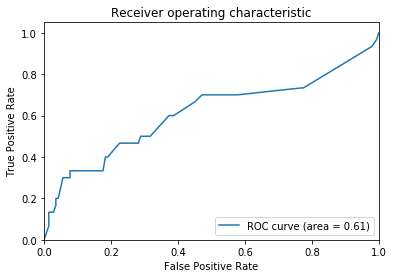

In [48]:
plot_roc_curve(y_val, get_auc_scores(model, X_smote[forward_selected_feature_list], X_val[forward_selected_feature_list], y_smote, y_val))


Training AUC: 0.7053903528039618
Testing AUC:  0.7548554652213189


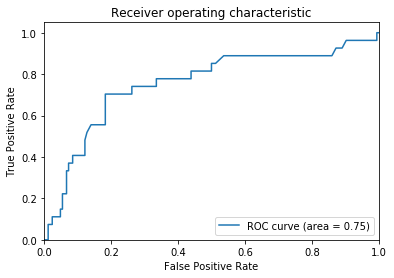

In [83]:
plot_roc_curve(y_test, get_auc_scores(model, X_smote, X_test, y_smote, y_test))


# Ridge

In [51]:
model = LogisticRegression(penalty='l2', solver='liblinear')   

model.fit(X_smote[forward_selected_feature_list], y_smote)
pred = model.predict(X_test[forward_selected_feature_list])  

In [52]:
get_auc_scores(model, X_smote[forward_selected_feature_list], X_val[forward_selected_feature_list], y_smote, y_val)

Training AUC: 0.7049338102459326
Testing AUC:  0.6118544600938967


array([0.35538796, 0.27454847, 0.45435045, 0.27454847, 0.53894748,
       0.45356081, 0.63002731, 0.35538796, 0.71697101, 0.47078896,
       0.47078896, 0.51046844, 0.47078896, 0.47078896, 0.35538796,
       0.78879991, 0.85768183, 0.71697101, 0.57252671, 0.27454847,
       0.6957737 , 0.35538796, 0.27454847, 0.27454847, 0.78879991,
       0.45356081, 0.27454847, 0.35538796, 0.45356081, 0.27454847,
       0.6957737 , 0.27454847, 0.47377795, 0.27454847, 0.27454847,
       0.45356081, 0.35538796, 0.45356081, 0.27454847, 0.3791388 ,
       0.35538796, 0.66114377, 0.46113462, 0.47377795, 0.47078896,
       0.5473413 , 0.5473413 , 0.5473413 , 0.27454847, 0.27454847,
       0.27454847, 0.35538796, 0.19047262, 0.47377795, 0.35538796,
       0.27454847, 0.71697101, 0.27454847, 0.74540056, 0.27454847,
       0.78679505, 0.45356081, 0.45356081, 0.57252671, 0.66114377,
       0.5473413 , 0.27454847, 0.5473413 , 0.49931223, 0.35538796,
       0.3791388 , 0.47078896, 0.19047262, 0.51046844, 0.45356

In [53]:
## hyper parameter tuning
clf = LogisticRegression(penalty='l2',  solver='liblinear')



best_roc_auc = -10**10

roc_auc_list = []

param_list = []




parameters = np.arange(0.001,1,0.001)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_smote[forward_selected_feature_list], y_smote)
    y_test_score = clf.predict_proba(X_val[forward_selected_feature_list])[:, 1]
    
    roc_auc_result = roc_auc_score(y_val, y_test_score)
    
    roc_auc_list.append(roc_auc_result)
    param_list.append(param)
    
    if roc_auc_result>best_roc_auc:
        best_roc_auc = roc_auc_result
        best_roc_auc_param = param
        
        
        
print("best roc_auc parameter : ",best_roc_auc_param)
print("ROC_AUC SCORE : ", best_roc_auc)
print()



best roc_auc parameter :  0.028
ROC_AUC SCORE :  0.6120892018779343



In [54]:
clf = LogisticRegression(penalty='l2',  solver='liblinear', C = 0.028)
clf.fit(X_smote[forward_selected_feature_list], y_smote)

LogisticRegression(C=0.028, solver='liblinear')

Training AUC: 0.7028668851492295
Testing AUC:  0.6120892018779343


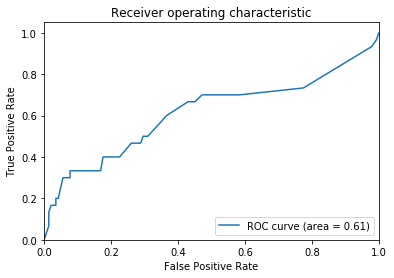

In [111]:
plot_roc_curve(y_val, get_auc_scores(clf, X_smote[forward_selected_feature_list], X_val[forward_selected_feature_list], y_smote, y_val))


Training AUC: 0.7028668851492295
Testing AUC:  0.7654697380307137


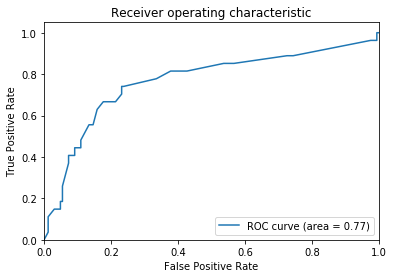

In [56]:
plot_roc_curve(y_test, get_auc_scores(clf, X_smote[forward_selected_feature_list], X_test[forward_selected_feature_list], y_smote, y_test))


# Lasso

In [57]:
model = LogisticRegression(penalty='l1', solver='liblinear')  

model.fit(X_smote[forward_selected_feature_list], y_smote)
pred = model.predict(X_val[forward_selected_feature_list])  

In [58]:
def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    '''Prints the AUC scores for training and testing data
    and returns testing score'''

    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    print('Training AUC:' , roc_auc_score(y_train, y_train_score))
    print('Testing AUC: ', roc_auc_score(y_test, y_test_score))
    
    return y_test_score


In [59]:
## hyperparameter tuning
clf = LogisticRegression(penalty='l1',  solver='liblinear')



best_roc_auc = -10**10

roc_auc_list = []

param_list = []




parameters = np.arange(1,3,0.01)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_smote[forward_selected_feature_list], y_smote)
    y_test_score = clf.predict_proba(X_val[forward_selected_feature_list])[:, 1]
    
    roc_auc_result = roc_auc_score(y_val, y_test_score)
    
    roc_auc_list.append(roc_auc_result)
    param_list.append(param)
    
    if roc_auc_result>best_roc_auc:
        best_roc_auc = roc_auc_result
        best_roc_auc_param = param
        
        
print("best roc_auc parameter : ",best_roc_auc_param)
print("ROC_AUC SCORE : ", best_roc_auc)
print()



best roc_auc parameter :  1.02
ROC_AUC SCORE :  0.6118544600938967



In [60]:
clf = LogisticRegression(penalty='l1',  solver='liblinear', C = 1.02)
clf.fit(X_smote[forward_selected_feature_list], y_smote)

LogisticRegression(C=1.02, penalty='l1', solver='liblinear')

In [61]:
 X_smote[forward_selected_feature_list]

,TILS,ModDiff,RightSide,Female,NoNecrosis,Under50,HistHet
0,1,1,1,1,1,0,1
1,0,0,1,0,0,0,0
2,0,1,1,1,1,0,1
3,1,0,0,0,1,0,0
4,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...
2589,1,1,1,1,1,0,0
2590,0,1,0,0,1,0,0
2591,1,1,1,1,1,0,0
2592,1,1,1,1,1,0,1


Training AUC: 0.7051222529424108
Testing AUC:  0.6118544600938967


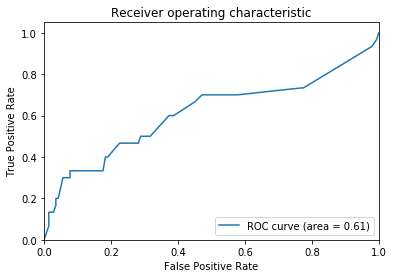

In [62]:
plot_roc_curve(y_val, get_auc_scores(clf, X_smote[forward_selected_feature_list], X_val[forward_selected_feature_list], y_smote, y_val))


Training AUC: 0.7051222529424108
Testing AUC:  0.7530487804878049


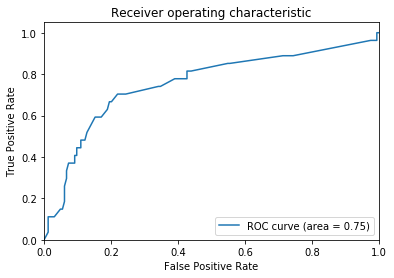

In [63]:
plot_roc_curve(y_test, get_auc_scores(clf, X_smote[forward_selected_feature_list], X_test[forward_selected_feature_list], y_smote, y_test))


# Elastic net

In [130]:
## hyperparameter tuning
clf = SGDClassifier(loss='log', penalty='elasticnet')
#                                         alpha=0.0001, l1_ratio=0.15)



best_roc_auc = -10**10

roc_auc_list = []

param_list = []




parameters_alpha = np.arange(0.01,2,0.1)
parameters_l1 = np.arange(0.01,1,0.01)

for param1 in parameters_alpha:
    for param2 in parameters_l1:
        clf.set_params(alpha = param1, l1_ratio = param2 )
        clf.fit(X_smote[forward_selected_feature_list], y_smote)
        y_test_score = clf.predict_proba(X_val[forward_selected_feature_list])[:, 1]

        roc_auc_result = roc_auc_score(y_val, y_test_score)

        roc_auc_list.append(roc_auc_result)
        param_list.append(param)

        if roc_auc_result>best_roc_auc:
            best_roc_auc = roc_auc_result
            best_roc_auc_param = (param1, param2)
        
        
print("best roc_auc parameter : ",best_roc_auc_param)
print("ROC_AUC SCORE : ", best_roc_auc)
print()



best roc_auc parameter :  (0.41000000000000003, 0.09)
ROC_AUC SCORE :  0.6582159624413144



In [64]:
clf = SGDClassifier(loss='log', penalty='elasticnet', alpha = 0.41, l1_ratio = 0.09)
clf.fit(X_smote[forward_selected_feature_list], y_smote)

SGDClassifier(alpha=0.41, l1_ratio=0.09, loss='log', penalty='elasticnet')

In [65]:
get_auc_scores(clf, X_smote[forward_selected_feature_list], X_test[forward_selected_feature_list], y_smote, y_test)

Training AUC: 0.6840778999517895
Testing AUC:  0.7846657633243


array([0.52481048, 0.49844667, 0.50431136, 0.50431136, 0.49062077,
       0.49844667, 0.49062077, 0.51213608, 0.50331202, 0.49062077,
       0.49844667, 0.49844667, 0.50331202, 0.49062077, 0.49062077,
       0.50431136, 0.49062077, 0.49844667, 0.49844667, 0.49062077,
       0.49844667, 0.49844667, 0.49844667, 0.49844667, 0.49062077,
       0.51113723, 0.49062077, 0.49062077, 0.50331202, 0.49062077,
       0.51113723, 0.49062077, 0.50431136, 0.51113723, 0.49062077,
       0.49844667, 0.49062077, 0.51113723, 0.49062077, 0.50431136,
       0.49062077, 0.49844667, 0.51699732, 0.49062077, 0.49844667,
       0.49062077, 0.52481048, 0.49062077, 0.51699732, 0.49062077,
       0.51213608, 0.50331202, 0.49062077, 0.49062077, 0.50331202,
       0.51113723, 0.49062077, 0.49062077, 0.49844667, 0.50431136,
       0.49062077, 0.49062077, 0.49844667, 0.49844667, 0.50431136,
       0.49062077, 0.49844667, 0.49062077, 0.49844667, 0.49844667,
       0.52481048, 0.49062077, 0.49062077, 0.50331202, 0.50331

Training AUC: 0.6840778999517895
Testing AUC:  0.7846657633243


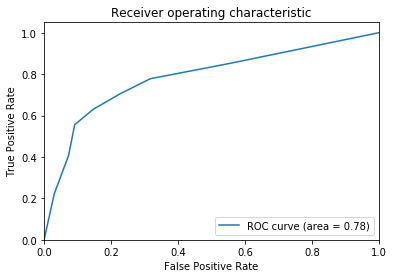

In [66]:
plot_roc_curve(y_test, get_auc_scores(clf, X_smote[forward_selected_feature_list], X_test[forward_selected_feature_list], y_smote, y_test))
